In [1]:
import numpy as np
import tensorflow as tf
import struct
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

1.10.1


In [2]:
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)
    
training_data = read_idx('./MNIST/train-images-idx3-ubyte')
training_labels = read_idx('./MNIST/train-labels-idx1-ubyte')

# Normalize the training data.
training_data = np.expand_dims(training_data, 3)
print(training_data.shape)
normalized_training_data = (training_data / 255) * 2 - 1


(60000, 28, 28, 1)


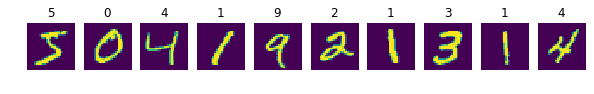

In [3]:
fig, ax = plt.subplots(1,10,figsize=(10,10))
for i in range(10):
    ax[i].imshow(training_data[i,:,:,0])
    ax[i].axis('off')
    ax[i].set_title(training_labels[i])

In [4]:
# Define the hyperparameters of the model.

# We will train with batches of 64. Consisting out of 32 true images and 32 generated.
generated_images_n = 32
real_images_n = 32

# The random noise vector will have dimension 50.
z_dim = 50



In [5]:
tf.reset_default_graph()

# Create the dataset.
training_dataset = tf.data.Dataset.from_tensor_slices((normalized_training_data, training_labels))


# Shuffle the training data in each iteration.
training_dataset = training_dataset.shuffle(buffer_size = 60000)

# Specify the batch sizes.
training_dataset = training_dataset.batch(real_images_n, drop_remainder=True)



In [6]:
# Create the iterator.
iterator = tf.data.Iterator.from_structure(training_dataset.output_types,
                                           training_dataset.output_shapes)

# Name the operation that will give the next batch and name the 
# initialization operations.
next_batch = iterator.get_next()
training_init_op = iterator.make_initializer(training_dataset)

In [7]:
# We will define functions for the layers so our code is not redundant.

def feed_forward_layer(x, hidden_n, activation_fn, normalize):        
    initializer = tf.random_normal_initializer(stddev=0.02)

    weights = tf.get_variable("weights", [x.shape[1], hidden_n], tf.float32, initializer)
    biases = tf.get_variable("biases", [hidden_n], tf.float32, tf.zeros_initializer())
    
    drive = tf.matmul(x, weights) + biases
    
    if normalize:
        drive = batch_norm(drive, [0])
    
    if activation_fn == 'linear':
        return drive
    else:
        return activation_fn(drive)



def conv_layer(x, kernels_n, kernel_size, stride_size, activation_fn, normalize):
    initializer = tf.random_normal_initializer(stddev=0.02)
    
    kernels = tf.get_variable("kernels", [kernel_size, kernel_size, x.shape[-1], kernels_n], tf.float32, initializer)
    biases = tf.get_variable("biases", [kernels_n], tf.float32, tf.zeros_initializer())

    drive = tf.nn.conv2d(x, kernels, strides = [1, stride_size, stride_size, 1], padding = "SAME") + biases
    
    if normalize:
        drive = batch_norm(drive, [0,1,2])
    
    return activation_fn(drive)




def back_conv_layer(x, target_shape, kernel_size, stride_size, activation_fn, normalize):
    initializer = tf.random_normal_initializer(stddev=0.02)
    
    kernels = tf.get_variable("kernels", [kernel_size, kernel_size, target_shape[-1], x.shape[-1]], tf.float32, initializer)
    biases = tf.get_variable("biases", [target_shape[-1]], tf.float32, tf.zeros_initializer())

    drive = tf.nn.conv2d_transpose(x, kernels, target_shape, strides = [1, stride_size, stride_size, 1], padding = "SAME") + biases
    
    if normalize:
        drive = batch_norm(drive, [0,1,2])
    
    return activation_fn(drive)


def flatten(x):
    size = int(np.prod(x.shape[1:]))
    return tf.reshape(x, [-1, size])


def batch_norm(x, axes):
    mean, var = tf.nn.moments(x, axes = axes)
    
    offset_initializer = tf.constant_initializer(0.0)
    offset = tf.get_variable("offset", [x.shape[-1]], tf.float32, offset_initializer)
    scale_initializer = tf.constant_initializer(1.0)
    scale = tf.get_variable("scale", [x.shape[-1]], tf.float32, scale_initializer)
    
    return tf.nn.batch_normalization(x, mean, var, offset, scale, 1e-6)

   

In [8]:
# First create the generator network.
z = tf.placeholder(tf.float32, [generated_images_n, z_dim])

# generator network
with tf.variable_scope("generator_layer_1", reuse=tf.AUTO_REUSE):
    gen_layer_1 = feed_forward_layer(z, 1024, tf.nn.relu, True)
    gen_layer_1 = tf.reshape(gen_layer_1, [generated_images_n, 4, 4, 64])
    
    
with tf.variable_scope("generator_layer_2", reuse=tf.AUTO_REUSE):
    gen_layer_2 = back_conv_layer(gen_layer_1, [generated_images_n, 7, 7, 32], 5, 2, tf.nn.relu, True)
    
with tf.variable_scope("generator_layer_3", reuse=tf.AUTO_REUSE):
    gen_layer_3 = back_conv_layer(gen_layer_2, [generated_images_n, 14, 14, 16], 5, 2, tf.nn.relu, True)    
    
with tf.variable_scope("generator_layer_4", reuse=tf.AUTO_REUSE):
    generated_images = back_conv_layer(gen_layer_3, [generated_images_n, 28, 28, 1], 5, 2, tf.nn.tanh, False)

 # get real images and concatenate real with generated   
real_images = tf.cast(next_batch[0], dtype=tf.float32)
real_and_generated_images = tf.concat([real_images, generated_images],0)



with tf.variable_scope("discriminator_layer_1", reuse=tf.AUTO_REUSE):
    dis_layer_1 = conv_layer(real_and_generated_images, 8, 5, 2, tf.nn.leaky_relu, True)
    
with tf.variable_scope("discriminator_layer_2", reuse=tf.AUTO_REUSE):
    dis_layer_2 = conv_layer(dis_layer_1, 16, 5, 2, tf.nn.leaky_relu, True)
    
with tf.variable_scope("discriminator_layer_3", reuse=tf.AUTO_REUSE):
    dis_layer_3 = conv_layer(dis_layer_2, 32, 5, 2, tf.nn.leaky_relu, True)
    
with tf.variable_scope("discriminator_layer_4", reuse=tf.AUTO_REUSE):
    flat = flatten(dis_layer_3)
    logits = feed_forward_layer(flat, 1, "linear", True)
    

In [1]:
# we apply two losses one to the discriminator one to the generator

# discriminator loss
with tf.variable_scope("dis_loss"):
    dis_labels = tf.concat([tf.ones([generated_images_n,1]), tf.zeros([real_images_n,1])], axis=0)
    dis_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=dis_labels)
    dis_loss = tf.reduce_mean(dis_cross_entropy)
    
# generator loss  
with tf.variable_scope("gen_loss"):
    gen_labels = tf.ones([generated_images_n,1])
    gen_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits[generated_images_n:], labels=gen_labels)
    gen_loss = tf.reduce_mean(gen_cross_entropy)
    
# get the generator and discriminator variables
with tf.variable_scope("variables"):
    trainable_variables = tf.trainable_variables()
    dis_variables = [var for var in trainable_variables if "discriminator" in var.name]
    gen_variables = [var for var in trainable_variables if "generator" in var.name]

    

with tf.variable_scope("optimizer", reuse=tf.AUTO_REUSE):
    learning_rate = 0.0004
    beta1 = 0.5
    dis_optimizer = tf.train.AdamOptimizer(learning_rate, beta1 = beta1)
    gen_optimizer = tf.train.AdamOptimizer(learning_rate, beta1 = beta1)

    dis_training_step = dis_optimizer.minimize(dis_loss, var_list = dis_variables)
    gen_training_step = gen_optimizer.minimize(gen_loss, var_list = gen_variables)    

    
tf.summary.scalar("dis_loss", dis_loss)
tf.summary.scalar("gen_loss", gen_loss)
merged_summaries = tf.summary.merge_all()
writer = tf.summary.FileWriter("./summaries/")


NameError: name 'tf' is not defined

In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    global_step = 0
    test_z = np.random.uniform(-1,1,[generated_images_n, z_dim]) 

    
    for _ in range(2):
        sess.run(training_init_op)
        while True:
            try:
                z_values = np.random.uniform(-1,1,[generated_images_n, z_dim]) 
                summaries, _, _, = sess.run((merged_summaries,
                                                 dis_training_step,
                                                 gen_training_step),
                                                 feed_dict={
                                                     z: z_values                                                      

                                                 })
                
                
                test_images = sess.run((generated_images), feed_dict={z:test_z})
                if global_step % 100 == 0:
                    for i in range(generated_images_n):
                        test_generated = test_images[i,:,:,0]
                        test_generated = np.floor((test_generated + 1) * 0.5 * 255)
                        im = Image.fromarray(test_generated)
                        im = im.convert("L")
                        im.save("./images/{}_{}.png".format(global_step,i))
                writer.add_summary(summaries, global_step = global_step)
                global_step += 1
            except tf.errors.OutOfRangeError:
                break